In [1]:
import sys
sys.path.append('../src')
from semantic_bac_segment.data_loader import BacSegmentDataset, collate_fn
from torch.utils.data import DataLoader

image_dir, mask_dir='../data/train/source', '../data/train/mask'
test_img_dir, test_mask_dir='../data/test/source', '../data/test/mask'
patch_size=128


dataset = BacSegmentDataset(image_dir, 
                            mask_dir, 
                            mode='train', 
                            patch_size=patch_size, 
                            subsetting=0, 
                            filter_threshold=0.000001, 
                            precision='float')
val_dataset = BacSegmentDataset(test_img_dir, 
                                test_mask_dir, 
                                mode='validation', 
                                patch_size=patch_size, 
                                subsetting=0, 
                                precision='float')
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)



In [36]:
class TrainSplit:
    def __init__(self, image_path, mask_path, val_ratio=0.1):
        self.image_path = image_path
        self.mask_path = mask_path
        self.val_ratio = val_ratio
        
    def get_samplepairs(self):
        assert os.path.exists(self.image_path), "Image directory does not exist"
        assert os.path.exists(self.mask_path), "Mask directory does not exist"

        image_files = sorted(glob.glob(os.path.join(self.image_path, '*')))
        mask_files = sorted(glob.glob(os.path.join(self.mask_path, '*')))

        assert len(image_files) == len(mask_files), "Number of images and masks do not match"
        self.image_mask_pairs = list(zip(image_files, mask_files))

        return self.image_mask_pairs

    def split_samples(self, verbose=True):
        train_dicts, valid_dicts = self.image_mask_pairs, []
        if self.val_ratio > 0:

            # Obtain & shuffle data indices
            num_data_dicts = len(self.image_mask_pairs)
            indices = np.arange(num_data_dicts)
            np.random.shuffle(indices)

            # Divide train/valid indices by the proportion
            valid_size = int(num_data_dicts * self.val_ratio)
            train_indices = indices[valid_size:]
            valid_indices = indices[:valid_size]

            # Assign data dicts by split indices
            train_dicts = [self.image_mask_pairs[idx] for idx in train_indices]
            valid_dicts = [self.image_mask_pairs[idx] for idx in valid_indices]
            
            if verbose:
                print(f"\n(DataLoaded) Training data size: {len(train_dicts)}, Validation data size: {len(valid_dicts)}\n")

        return train_dicts, valid_dicts

In [41]:
import os 
import numpy as np

splitter=TrainSplit('../data/train/source', '../data/train/mask', .5)
splitter.get_samplepairs()
x, y=splitter.split_samples()

x


(DataLoaded) Training data size: 7, Validation data size: 7



[('../data/train/source/img_8.tiff', '../data/train/mask/img_8.tiff'),
 ('../data/train/source/mabs_img_4.tif', '../data/train/mask/mabs_img_4.tif'),
 ('../data/train/source/img_1.tiff', '../data/train/mask/img_1.tiff'),
 ('../data/train/source/img_10.tiff', '../data/train/mask/img_10.tiff'),
 ('../data/train/source/mabs_img_2.tif', '../data/train/mask/mabs_img_2.tif'),
 ('../data/train/source/img_7.tiff', '../data/train/mask/img_7.tiff'),
 ('../data/train/source/mabs_img_1.tif', '../data/train/mask/mabs_img_1.tif')]

/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_49714/3260009216.py:5: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(path, edges)


(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x13fbb9250>)

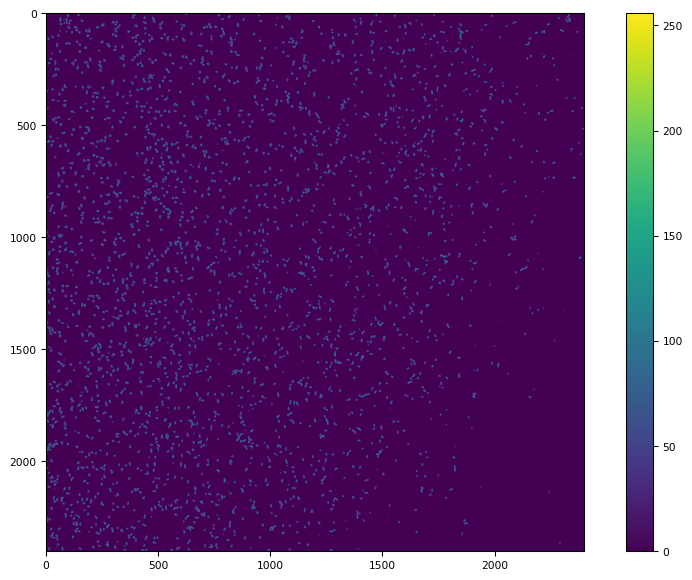

In [35]:
import cv2
edges = cv2.Canny(cv2.convertScaleAbs(img), 100, 200)

path = os.path.expanduser("~/Desktop/edges.png")
tifffile.imsave(path, edges)

tifffile.imshow(edges)

In [11]:
import math
def simple_stich(image, patch_size=128):
    image.shape
    steps = int(math.sqrt(image.shape[0]))
    image_patches = image.reshape(steps, steps, patch_size, patch_size)
    stitched_image = np.zeros((14 * 128, 14 * 128))
    # Iterate over the patches and stitch them into the image
    for i in range(steps):
        for j in range(steps):
            patch = image_patches[i, j]
            x_start = i * patch_size
            x_end = (i + 1) * patch_size
            y_start = j * patch_size
            y_end = (j + 1) * patch_size
            stitched_image[x_start:x_end, y_start:y_end] = patch
    return stitched_image

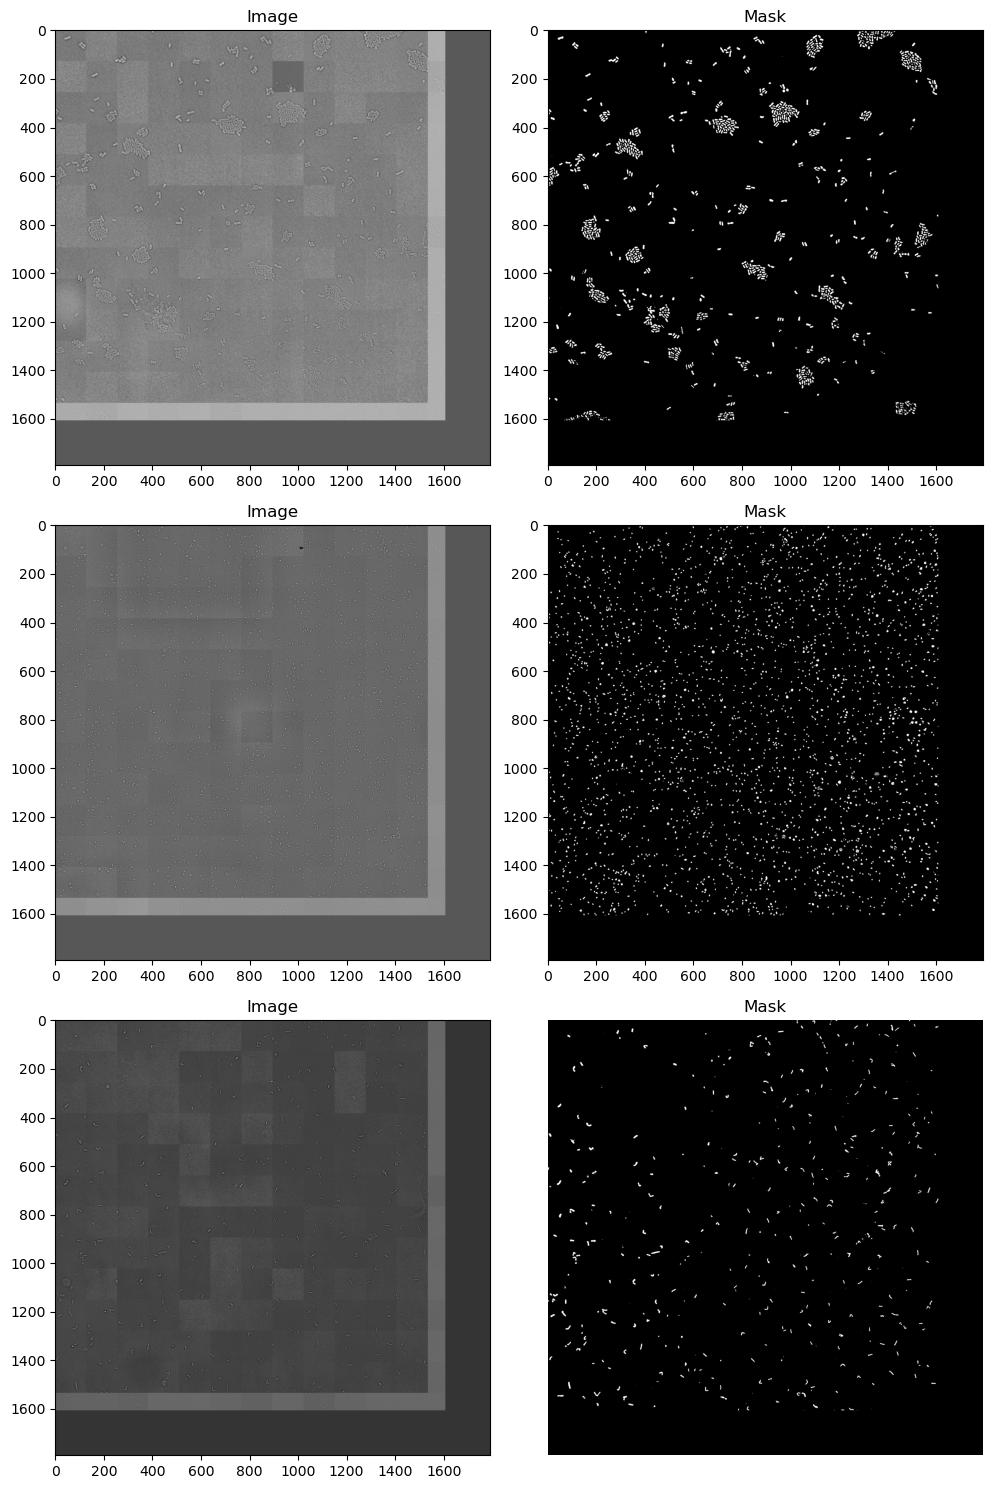

In [19]:
import matplotlib.pyplot as plt

# Create a figure with 2 columns and 3 rows
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Iterate over the images and masks
for idx, (image, mask) in enumerate(val_dataset):

    image = image.numpy()
    mask = mask.numpy()
    # Apply the simple_stich function to the image
    stitched_image = simple_stich(image)

    # Apply the simple_stich function to the mask
    stitched_mask = simple_stich(mask)

    # Calculate the row and column indices for plotting

    # Plot the stitched image and mask side by side
    axs[idx, 0].imshow(stitched_image *55, cmap='gray')
    axs[idx, 0].set_title('Image')
    axs[idx, 1].imshow(stitched_mask, cmap='gray')
    axs[idx, 1].set_title('Mask')

# Remove empty subplots
if len(val_dataset) % 2 != 0:
    axs[-1, -1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
import tifffile

tifffile.imwrite('../stiched_mask.tiff', stitched_mask)

In [4]:
def normalize_percentile(x, pmin=1, pmax=99.8, clip=False, dtype=np.float32):
    """
    Percentile-based image normalization.

    Args:
        x (numpy.ndarray): Input array.
        pmin (float): Lower percentile value (default: 1).
        pmax (float): Upper percentile value (default: 99.8).
        clip (bool): Whether to clip the output values to the range [0, 1] (default: False).
        dtype (numpy.dtype): Output data type (default: np.float32).

    Returns:
        numpy.ndarray: Normalized array.
    """

    x = x.astype(dtype, copy=False)
    mi = np.percentile(x, pmin)
    ma = np.percentile(x, pmax)
    eps = np.finfo(dtype).eps  # Get the smallest positive value for the data type

    x = (x - mi) / (ma - mi + eps)

    if clip:
        x = np.clip(x, 0, 1)

    return x


In [7]:
img=tifffile.imread('../data/test/source/img_2.tiff')

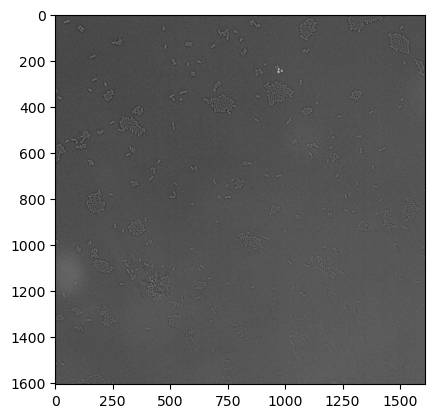

In [10]:
plt.imshow(normalize_percentile(img), cmap='gray')